In [1]:
import cv2
import torch
import torchvision.ops.boxes as bops
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def intersect(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    torch_box1 = torch.tensor(np.array([[x1, y1, x1 + w1, y1 + h1]]), dtype=torch.float)
    torch_box2 = torch.tensor(np.array([[x2, y2, x2 + w2, y2 + h2]]), dtype=torch.float)
    iou = bops.box_iou(torch_box1, torch_box2)
    return not not iou.any()

def longest_edge(contour):
    prev_diff = None
    length = 0
    max_length = 0
    for i in range(len(contour) - 1):
        diff = contour[i] - contour[i + 1]
        if (diff == prev_diff).all():
            length += 1
        else:
            length = 1
        prev_diff = diff
        max_length = max(length, max_length)
    return max_length

def get_contours(img_hsv, img_gray, hsv_values):
    mask = cv2.inRange(img_hsv, hsv_values, hsv_values)
    img = cv2.bitwise_and(img_gray, img_gray, mask=mask)
    img[img != 0] = 255
    _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(image=thresh, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
    return contours, thresh

def find_clouds(file_name):
    img = cv2.imread(file_name)

    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask_drop = cv2.inRange(img_hsv, (119, 159, 185), (119, 159, 185))
    img[:, :1317, :][mask_drop[:, :1317] > 0] = (187, 176, 160)
    
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    contours_drizzle, _ = get_contours(img_hsv, img_gray, (102, 221, 243))
    contours_melt, _ = get_contours(img_hsv, img_gray, (19, 255, 255))
    contours_ice, thresh = get_contours(img_hsv, img_gray, (102, 37, 187))

    # Watershed segmentation, code adapted from https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html
    # I tried other implementations from Scikit-image but it did not work better (https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_watershed.html)
    kernel = np.array([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=np.float32)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(thresh, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    # Second argument in the line below affects how the clouds are segmented,
    # I think that a higher value generally creates more segmentations
    # Very fiddly as different clouds will require different thresholds based on
    # how thin the region of contact between blobs of clouds are
    ret, sure_fg = cv2.threshold(dist_transform, 0.3 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    ret, markers = cv2.connectedComponents(sure_fg)
    markers += 1
    markers[unknown == 255] = 0
    markers = cv2.watershed(img, markers)
    markers = np.uint8(markers)
    contours_ice = []
    
    for i in range(2, int(ret) + 1):
        _, thresh = cv2.threshold(np.uint8(markers == i), 150, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        contour, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours_ice += contour

    contours_ice = [contour for contour in contours_ice if cv2.contourArea(contour) > 0]
    contours_melt = [contour for contour in contours_melt if cv2.contourArea(contour) > 0]
    contours_drizzle = [contour for contour in contours_drizzle if cv2.contourArea(contour) > 0]
    
    box_melt = []
    box_ice = []
    box_drizzle = []
    box_corrupt = []
    to_remove = []
    
    for contour in contours_ice:
        x, y, w, h = cv2.boundingRect(contour)
        if y < 42 or x > 1317:
            box_corrupt.append([x, y, w, h])
        box_ice.append([x, y, w, h])
    
    for contour in contours_melt:
        x, y, w, h = cv2.boundingRect(contour)
        y -= 2
        box_melt.append([x, y, w, h])

    for contour in contours_drizzle:
        x, y, w, h = cv2.boundingRect(contour)
        y -= 2
        box_drizzle.append([x, y, w, h])
    
    for i, v in enumerate(box_ice):
        if longest_edge(contours_ice[i]) / cv2.arcLength(contours_ice[i], True) > 0.3:
            to_remove.append(i)
        else:
            for j in box_melt + box_drizzle + box_corrupt:
                if intersect(v, j):
                    to_remove.append(i)
                    break
    
    for i in sorted(to_remove, reverse=True):
        contours_ice.pop(i)
    
    cv2.drawContours(image=img, contours=contours_ice, contourIdx=-1, color=(0, 255, 0), thickness=1, lineType=cv2.LINE_AA)
    return img, contours_ice

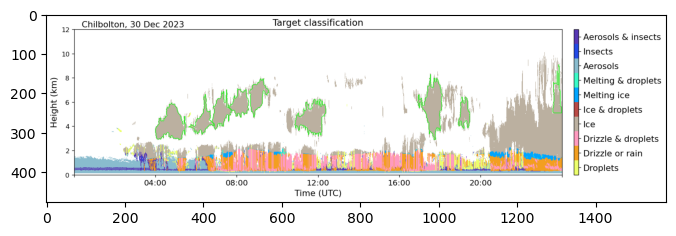

In [3]:
file_name = 'cloudnet-collection/20231230_chilbolton_classification.png'
img, contours_ice = find_clouds(file_name)
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.show()